## DQN-Training
Experiment 1-DQN-Training in the CartPole Experiments folder describes in detail, how a DQN is trained. This notebook therefore only contains the relevant code. For additional comments, see the CartPole experiment or check our thesis. We first train a conventional DQN and then a spiking DSQN. Loading and converting is omitted completely for MountainCar. The CartPole experiments can simply be adapted by setting the environment to MountainCar and loading the networks trained in this notebook. The results of conversion and loading the MountainCar networks are reported in our thesis.

In [1]:
import torch
import torch.optim as optim
import os
import sys
import random
import matplotlib.pyplot as plt
# hack to perform relative imports
sys.path.append('../../')
from Code import train_agent, SQN, FullyConnected

Detected PyNN version 0.9.5 and Neo version 0.6.1


<div class="alert alert-block alert-warning">
<b>Attention:</b> If the directory with the specified name already exists, this will throw an error. You need to specify a different name or delete the old directory. If this happens, you should restart the kernel, as the directory is a relative path which changes everytime this cell is run.
</div>

In [2]:
# switch to the Result Directory
os.chdir('./../../Results/')
# choose the name of the result directory
result_directory = 'MountainCar-DQN-Training'
# create the result directory (throws an error if the directory already exists)
os.makedirs(result_directory)
os.chdir(result_directory)
# for the first experiment we create an additinonal sub folder
os.makedirs('DQN')
os.chdir('DQN')

In [3]:
# set seeds for reproducibility
torch_seed = 735
torch.manual_seed(torch_seed)
random_seed = 786
random.seed(random_seed)
gym_seed = 646

In [4]:
#define environment
env = 'MountainCar-v0'

#hyperparameters
BATCH_SIZE = 128
DISCOUNT_FACTOR = 0.999
EPSILON_START = 1.0
EPSILON_END = 0.05
EPSILON_DECAY = 0.999
TARGET_UPDATE_FREQUENCY = 5
LEARNING_RATE = 0.001
REPLAY_MEMORY_SIZE = 10**3
# minimum size of the replay memory before the training starts
INITIAL_REPLAY_SIZE = 0
# the gym standard for solving MountainCar is to reach a 100 episode average of -110 for 100 consecutive episodes
# as this is hard to reach, we relaxed the standard to reach a 100 episode average of -130 for 50 consecutive episodes
GYM_TARGET_AVG = -130
GYM_TARGET_DURATION = 50
# maximum number of steps before the environment is reset
MAX_STEPS = 200
# number of episodes to train the agent
NUM_EPISODES = 1000
# whether to use Double Q Learning and Gradient Clipping
DOUBLE_Q = True
GRADIENT_CLIPPING = True
# whether to render the environment
RENDER = True

# device: automatically runs on GPU, if a GPU is detected, else uses CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# initialize policy and target net
# for MountainCar we use a slightly larger network architecture
architecture = [2,64,64,3] 
policy_net = FullyConnected(architecture).to(device)

target_net = FullyConnected(architecture).to(device)
target_net.load_state_dict(policy_net.state_dict())

# initialize optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)


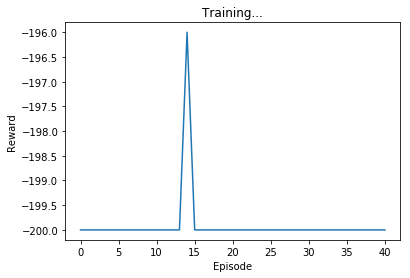

KeyboardInterrupt: 

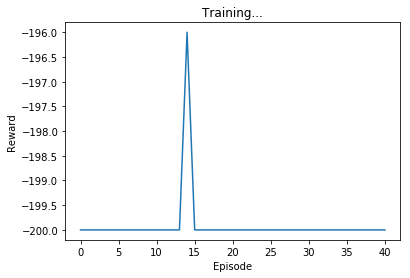

In [6]:
train_agent(env,policy_net,target_net,BATCH_SIZE,DISCOUNT_FACTOR,EPSILON_START,
            EPSILON_END,EPSILON_DECAY,TARGET_UPDATE_FREQUENCY,optimizer,LEARNING_RATE,
            REPLAY_MEMORY_SIZE,device,GYM_TARGET_AVG,GYM_TARGET_DURATION,num_episodes=NUM_EPISODES,
            max_steps=MAX_STEPS,render=RENDER,double_q_learning=DOUBLE_Q,gradient_clipping=GRADIENT_CLIPPING,
            initial_replay_size=INITIAL_REPLAY_SIZE,gym_seed=gym_seed, torch_seed=torch_seed, random_seed=random_seed)

In this plot, blue shows the reward in each individual episode and orange shows the 100 episode average.

Next, we train a DSQN using Backpropagation with surrogate gradients.

In [ ]:
# First we set up a new sub directory
os.chdir('./..')
os.makedirs('DSQN')
os.chdir('DSQN')
# We use a non-leaky integrate-and-fire neuron
ALPHA = 0
BETA = 1
# Simulation time is chosen relatively short, such that the network does not need too much time to run, but not too short,
# such that it can still learn something
SIMULATION_TIME = 20
# We also have to define the input/output and reset methods, to our knowledge, SpyTorch supports only potential outputs 
# and reset-by-subtraction. As input method we use constant input currents. It would be interesting to see if SpyTorch
# can also use reset-to-zero, as this would make it more similar to the iaf_delta models in NEST and SpyNNaker
ENCODING = 'constant'
DECODING = 'potential'
RESET = 'subtraction'
# SpyTorch uses a fixed threshold of one, we didn't test other thresholds, but should be possible
THRESHOLD = 1
# set new learning rate, as training reaches OpenAiGym standard more often with lower learning rate
LEARNING_RATE = 0.0005

In [ ]:
# set seeds
torch.manual_seed(555)
random.seed(454)
gym_seed = 328

In [ ]:
# set up network
architecture = [4,17,17,2]
policy_net = SQN(architecture,device,alpha=ALPHA,beta=BETA,simulation_time=SIMULATION_TIME,add_bias_as_observation=True,
                  encoding=ENCODING,decoding=DECODING,reset=RESET,threshold=THRESHOLD)

target_net = SQN(architecture,device,alpha=0,beta=1,simulation_time=SIMULATION_TIME,add_bias_as_observation=True,
                  encoding=ENCODING,decoding=DECODING,reset=RESET,threshold=THRESHOLD)
target_net.load_state_dict(policy_net.state_dict())

# initialize optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

In [ ]:
train_agent(env,policy_net,target_net,BATCH_SIZE,DISCOUNT_FACTOR,EPSILON_START,
            EPSILON_END,EPSILON_DECAY,TARGET_UPDATE_FREQUENCY,optimizer,LEARNING_RATE,
            REPLAY_MEMORY_SIZE,device,GYM_TARGET_AVG,GYM_TARGET_DURATION,num_episodes=NUM_EPISODES,
            max_steps=MAX_STEPS,render=RENDER,double_q_learning=DOUBLE_Q,gradient_clipping=GRADIENT_CLIPPING,
            initial_replay_size=INITIAL_REPLAY_SIZE,gym_seed=gym_seed)